In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import sparseqr

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator



################################################################################################################
################################################################################################################
################################################################################################################

class Graph_Function:

    def __init__(self, data, domain=None):

        self.data = data
        if domain is not None:
            self.domain = [edge_domain.copy() for edge_domain in domain]

    def __add__(self, other):

        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        result = [i + j for i, j in zip(self.data, other.data)]

        return Graph_Function(result, self.domain)

    def __sub__(self, other):

        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        result = [i - j for i, j in zip(self.data, other.data)]

        return Graph_Function(result, self.domain)

    def __mul__(self, other):

        if isinstance(other, Graph_Function):
            result = [i * j for i, j in zip(self.data, other.data)]

        elif np.isscalar(other):  
            result = [arr * other for arr in self.data]

        else:
            return NotImplemented
        
        return Graph_Function(result, self.domain)

    def __rmul__(self, other):

        return self.__mul__(other)

    def __truediv__(self, other):

        if isinstance(other, Graph_Function):
            result = [i / j for i, j in zip(self.data, other.data)]

        elif np.isscalar(other):  
            result = [arr / other for arr in self.data]

        else:
            return NotImplemented
        
        return Graph_Function(result, self.domain)

    def __rtruediv__(self, other):

        if np.isscalar(other):
            result = [other / arr for arr in self.data]

        else:
            return NotImplemented
        
        return Graph_Function(result, self.domain)

    def __eq__(self, other):

        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        return all(np.array_equal(i, j) for i, j in zip(self.data, other.data))

    def __repr__(self):

        return f"Graph_Function({self.data})"
    
    def norm(self):

        return np.sqrt(self.dot(self))
    
    def normalize(self):

        norm = self.norm()

        if norm == 0:
            raise ValueError("Cannot normalize a zero vector.")

        result = [arr / norm for arr in self.data]

        return Graph_Function(result, self.domain)
    
    def dot(self, other):
        
        if not isinstance(other, Graph_Function):
            return NotImplemented
        
        if (self.domain is None) and not (other.domain is None):
            self.domain = other.domain
        elif not (self.domain is None) and (other.domain is None):
            other.domain = self.domain
        elif (self.domain is None) and (other.domain is None):
            raise ValueError("Graph_Functions need domain attributes.")
        
        graph_inner_product = 0

        for f0_edge, f1_edge, edge in zip(self.data, other.data, self.domain):
            edge_length = np.linalg.norm([edge[0, 0] - edge[0, -1], edge[1, 0] - edge[1, -1]])
            edge_param = np.linspace(0, edge_length, edge.shape[1])
            graph_inner_product += scipy.integrate.trapezoid(f0_edge * f1_edge, edge_param)

        return graph_inner_product

def style_plot(fig, ax, aspect="equal", no_ticks=False, no_xticks=False, no_yticks=False):

    # Remove white space
    fig.tight_layout()

    # Makes axes aspect equal
    if aspect:
        ax.set_aspect(aspect)

    # Make tick labels bold font
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(20)

    # Make border thicker
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

    # xy_ticks
    major_tick_length = 7
    minor_tick_length = 4
    if no_ticks:
        major_xtick_length = 0
        major_ytick_length = 0
        minor_xtick_length = 0
        minor_ytick_length = 0
    elif no_xticks:
        major_xtick_length = 0
        major_ytick_length = major_tick_length
        minor_xtick_length = 0
        minor_ytick_length = minor_tick_length
    elif no_yticks:
        major_xtick_length = major_tick_length
        major_ytick_length = 0
        minor_xtick_length = minor_tick_length
        minor_ytick_length = 0
    else:
        major_xtick_length = major_tick_length
        major_ytick_length = major_tick_length
        minor_xtick_length = minor_tick_length
        minor_ytick_length = minor_tick_length
    ax.tick_params(axis='x', which='major', length=major_xtick_length, width=2, direction='out')
    ax.tick_params(axis='y', which='major', length=major_ytick_length, width=2, direction='out')
    ax.tick_params(axis='x', which='minor', length=minor_xtick_length, width=1, direction='out')
    ax.tick_params(axis='y', which='minor', length=minor_ytick_length, width=1, direction='out')

In [5]:
continuum_eigendata = solve_laplace_operator.solve_laplace_operator.Continuum_Eigendata("square_flat_torus")

continuum_eigendata.calculate_pde_eigenvalues(np.arange(5), np.arange(5))

array([[ 0.        ,  4.44288294,  8.88576588, 13.32864881, 17.77153175],
       [ 4.44288294,  6.28318531,  9.93458827, 14.04962946, 18.31847564],
       [ 8.88576588,  9.93458827, 12.56637061, 16.01904224, 19.86917653],
       [13.32864881, 14.04962946, 16.01904224, 18.84955592, 22.21441469],
       [17.77153175, 18.31847564, 19.86917653, 22.21441469, 25.13274123]])

In [6]:
# file = open("tiling/square_periodic/eigenvalue_data.pkl", "rb")
# eigenvalue_data = pickle.load(file)
# file.close()

# file = open("tiling/square_periodic/eigendata.pkl", "rb")
# full_data = pickle.load(file)
# file.close()

In [12]:
powers_of_10_lims = (2, 4)
num_Vs_per_tile = 4
num_graphs_per_power_of_10 = 5
total_dpowers = num_graphs_per_power_of_10 * (powers_of_10_lims[1] - powers_of_10_lims[0]) + 1
power_linspace = np.linspace(powers_of_10_lims[0], powers_of_10_lims[1], total_dpowers)

tiles_per_dim = np.int32(np.sqrt(10**power_linspace / num_Vs_per_tile))

mn = [[0, 0], [0, 1], [0, 2], [1, 1], [1, 2], [2, 2]]

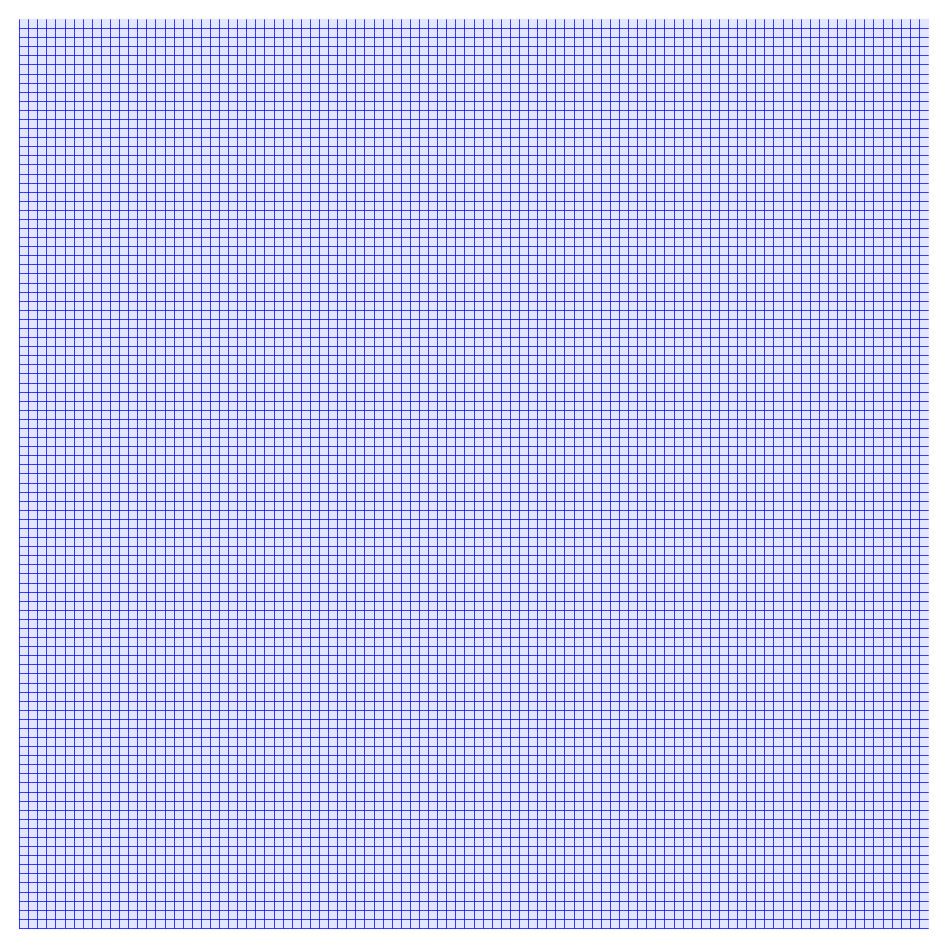

In [18]:
g = construct_graph.tiling.Tiling(tile_type='square_tile',
                                    num_horizontal_displacements=tiles_per_dim[-1],
                                    num_vertical_displacements=tiles_per_dim[-1],
                                    autoplot=False)
fig, ax = g.plot_graph(return_figax=True, embedding_space='square')
plt.savefig("tiling/square_periodic/large_square_periodic_lattice.png", dpi=200, bbox_inches="tight")

In [8]:
run_eigenvalue_calculations = False

In [9]:
if run_eigenvalue_calculations:
    guesses = np.concatenate([np.array([1e-15]), np.linspace(3, 15, 300)])

    eigenvalue_data = {}

    for tile_num in tiles_per_dim[4:5]:
        g = construct_graph.tiling.Tiling(tile_type='square_tile',
                                          num_horizontal_displacements=tile_num,
                                          num_vertical_displacements=tile_num,
                                          autoplot=False)
        print(f"num_Vs = {g.num_Vs}")
        print("\n\n\n")
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        ks = eigs(guesses, printerval=np.inf, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
        _, index = np.unique(np.round(ks, 6), return_index=True)
        eigenvalues = ks[index]
        eigenvalue_data[g.num_Vs] = eigenvalues.copy()

run_eigenvalue_calculations = False

In [12]:
g = construct_graph.tiling.Tiling(tile_type='square_tile',
                                    num_horizontal_displacements=tiles_per_dim[4],
                                    num_vertical_displacements=tiles_per_dim[4],
                                    autoplot=False)

In [10]:
plot_and_save_continuum_modes = True

In [11]:
if plot_and_save_continuum_modes:

    g = construct_graph.tiling.Tiling(tile_type='square_tile',
                                        num_horizontal_displacements=tiles_per_dim[0],
                                        num_vertical_displacements=tiles_per_dim[0],
                                        autoplot=False)
    print(g.num_Vs)
    p = solve_laplace_operator.solve_laplace_operator.Projector(g, eigenvalue_data[g.num_Vs], continuum_eigendata)

    for m, n in mn:
        print(m, n)
        x, y, A = p.construct_pde_functions(m, n, function_domain="continuum")
        for en, a in enumerate(A):
            print(en)
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111)
            ax.pcolormesh(x, y, a, cmap="plasma", shading='auto')
            style_plot(fig, ax, aspect="equal", no_ticks=True)
            ax.axis('off')
            fig.set_facecolor("black")
            plt.savefig(f"tiling/square_periodic/PDE_mode_plots/continuum_eigenmode_m{m}_n{n}_number{en}.png", dpi=200, bbox_inches='tight')
            plt.close()

plot_and_save_continuum_modes = False

100
0 0
0
0 1
0
1
2
3
0 2
0
1
2
3
1 1
0
1
2
3
1 2
0
1
2
3
4
5
6
7
2 2
0
1
2
3


In [23]:
mn = [[0, 0], [0, 1], [0, 2], [1, 1], [1, 2], [2, 2]]

In [24]:
full_data = {}

for tile_num in tiles_per_dim:

    g = construct_graph.tiling.Tiling(tile_type='square_tile',
                                      num_horizontal_displacements=tile_num,
                                      num_vertical_displacements=tile_num,
                                      autoplot=False)
    print(g.num_Vs)
    p = solve_laplace_operator.solve_laplace_operator.Projector(g, eigenvalue_data[g.num_Vs], continuum_eigendata)
    for m, n in mn:
        print(m,n)
        p(m, n)
    full_data[g.num_Vs] = p.data

100
0 0
0 1
0 2
1 1
1 2
2 2
144
0 0
0 1
0 2
1 1
1 2
2 2


/Users/sidneyholden/repos/metric_graph/test_scripts/../solve_laplace_operator/solve_laplace_operator.py:471: UserWarning: For num_Vs=144,m=2,n=2, the graph eigenspace is larger than the PDE eigenspace. This might be (a) a problem, (b) saying something interesting, or (c) nothing special.
  warnings.warn(message)


196
0 0
0 1
0 2
1 1
1 2
2 2
324
0 0
0 1
0 2
1 1
1 2
2 2
576
0 0
0 1
0 2
1 1
1 2
2 2
900
0 0
0 1
0 2
1 1
1 2
2 2
1444
0 0
0 1
0 2
1 1
1 2
2 2
2500
0 0
0 1
0 2
1 1
1 2
2 2
3844
0 0
0 1
0 2
1 1
1 2
2 2
6084
0 0
0 1
0 2
1 1
1 2
2 2
10000
0 0
0 1
0 2
1 1
1 2
2 2


In [35]:
plot_and_save_modes = True

In [36]:
if plot_and_save_modes:

    g = construct_graph.tiling.Tiling(tile_type='square_tile',
                                        num_horizontal_displacements=tiles_per_dim[4],
                                        num_vertical_displacements=tiles_per_dim[4],
                                        autoplot=False)
    print(g.num_Vs)

    for m, n in mn:
        print(m, n)
        emodes = full_data[g.num_Vs][m, n]['PDE']['eigenfunction']
        for en, emode in enumerate(emodes):
            fig, ax = g.plot_graph(eigenmode=emode.data, return_figax=True, background_color="black")
            plt.savefig(f"tiling/square_periodic/mode_plots_continuum_on_graph/eigenmode_{g.num_Vs}Vs_m{m}_n{n}_number{en}.png", dpi=200, bbox_inches='tight')
            plt.close()

plot_and_save_modes = False

576
0 0
0 1
0 2
1 1
1 2
2 2


In [27]:
edata = solve_laplace_operator.solve_laplace_operator.Eigendata(full_data)

In [59]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
order_line_color = colors[6]
colors = colors[:6] + colors[7:]
def plot_loglog_rel_err(Num_Vs, rel_errs, show_legend=False, rate_slope=1., rate_scaling=1):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6), gridspec_kw={'height_ratios': [6, 1]})
    fig.subplots_adjust(hspace=0.2, )  # adjust space between axes

    # Separate data by size
    for en, rel_err in enumerate(rel_errs):
        if np.all(rel_err > 1e-10):
            ax1.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en], label=str(mn[en]))
        else:
            ax2.loglog(Num_Vs, rel_err, 'o-', markersize=10, c=colors[en], label=str(mn[en]))
            if np.any(rel_err > 1e-10):
                relevant_data = rel_err[rel_err <= 1e-10]
                ax2.set_ylim(0.1 * np.min(relevant_data), 10 * np.max(relevant_data))

    # Setup convergence line
    ax1_data_lims = (np.min(rel_errs[rel_errs > 1e-10]), np.max(rel_errs[rel_errs > 1e-10]))
    ax1_log_dif = np.log10(ax1_data_lims[1]) - np.log10(ax1_data_lims[0])
    max_order_height = np.max(rel_errs) / np.max(Num_Vs**(-1.))
    order_line_data = max_order_height * Num_Vs**(-rate_slope) * 10**(0.15 * ax1_log_dif) / rate_scaling
    # order_line_data = max_order_height * Num_Vs**(-1.) * 1
    ax1.loglog(Num_Vs, order_line_data, 
               linewidth=4, c=order_line_color)

    # hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # Slanted lines
    d = 0.5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=3, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    style_plot(fig, ax1, aspect=None, no_xticks=True)
    style_plot(fig, ax2, aspect=None)

    if show_legend:
        ax1.legend()
        ax2.legend()

    # ax1.set_ylim(2e-3, 4e0)

    # minor_ticks = ax2.yaxis.get_minorticklocs()
    # ax2.set_yticks(minor_ticks, minor=True)
    # ax2.set_yticklabels([], minor=True)

    return fig, fig.axes

In [60]:
mn = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]

(<Figure size 700x600 with 2 Axes>, [<Axes: >, <Axes: >])

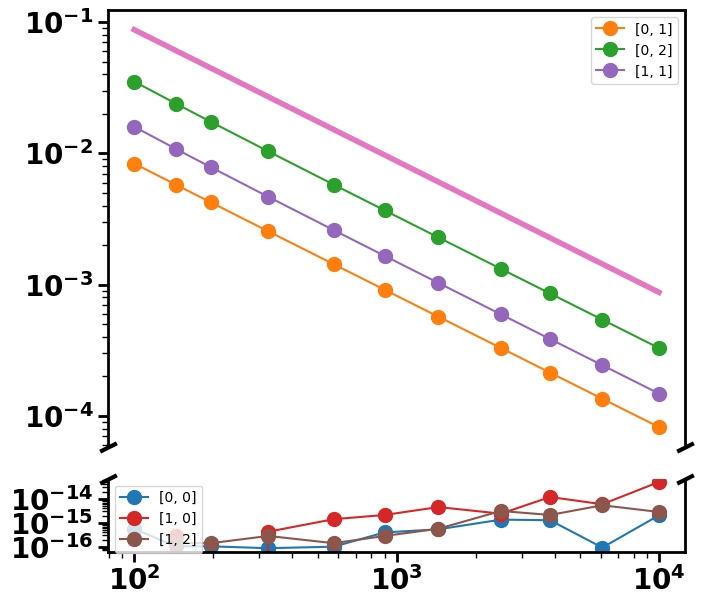

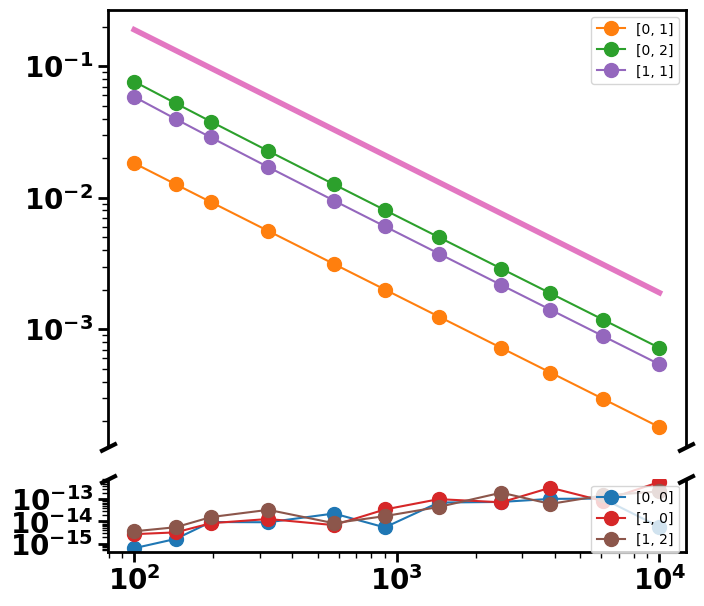

In [61]:
x = edata.V_nums
y = np.array(list(edata.relative_eigenvalue_differences.values()))
plot_loglog_rel_err(x, y, show_legend=True)

x = edata.V_nums
y = np.array(list(edata.relative_eigenfunction_differences.values()))
plot_loglog_rel_err(x, y, show_legend=True)